In [2]:
import torch
from torchvision import datasets, transforms

BATCH = 64
EPOCHS = 5

transform=transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))
])
dataset = datasets.MNIST('./mnist', train=True, download=True, transform=transform)
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [50000, 10000])
dataset_test = datasets.MNIST('./mnist', train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH)
validloader = torch.utils.data.DataLoader(dataset_valid, batch_size=BATCH)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH)


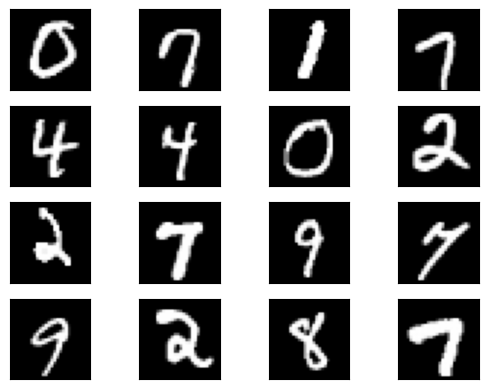

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(dataset_train[i][0].reshape(28, 28), cmap='Greys_r')

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 25, 12, stride=2, padding=0)
        self.conv2 = nn.Conv2d(25, 64, 5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(1024, 1024)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.dropout(x))
        x = self.fc2(x)
        return x


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=1e-4)

In [6]:
for epoch in range(EPOCHS):
    train_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        target = net(inputs)
        loss = criterion(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validloader:    
            target = net(inputs)
            loss = criterion(target,labels)
            valid_loss += loss.item() 
    print(f'Epoch {epoch+1} Training Loss: {train_loss / len(trainloader)} Validation Loss: {valid_loss / len(validloader)}')

PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

Epoch 1 Training Loss: 0.3794426581991451 Validation Loss: 0.15785744772025734
Epoch 2 Training Loss: 0.11071526113173465 Validation Loss: 0.10010856681260144
Epoch 3 Training Loss: 0.0735559176952552 Validation Loss: 0.08378834305271791
Epoch 4 Training Loss: 0.05541772665420209 Validation Loss: 0.07037461625269739
Epoch 5 Training Loss: 0.044251436975908456 Validation Loss: 0.060803711875549456


In [7]:
dataiter = iter(testloader)
images, labels = next(dataiter)

net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {correct/total}")

Accuracy: 0.9855


64


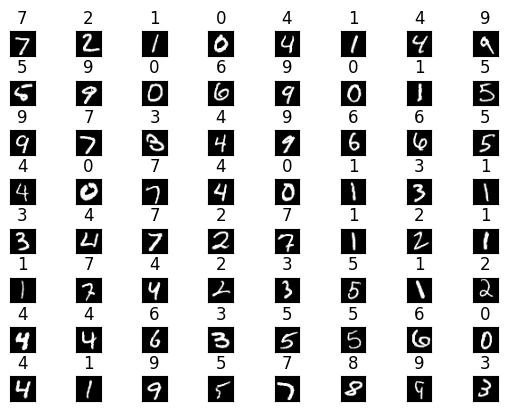

In [8]:
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        print(correct)
        break

fig = plt.figure()
fig.subplots_adjust(wspace=1, hspace=1)
for i in range(BATCH):
    ax = fig.add_subplot(8, 8, i + 1)
    ax.set_title(predicted[i].item())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(dataset_test[i][0].reshape(28, 28), cmap='Greys_r')
